In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.13498  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")

# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

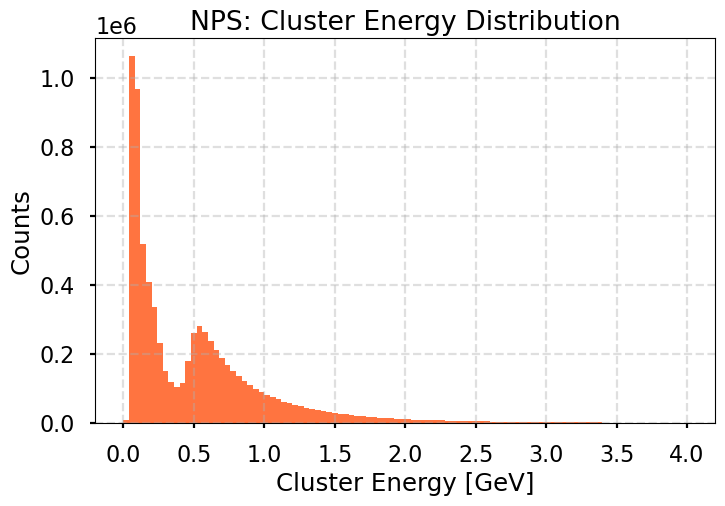

In [2]:
clusE = ak.to_numpy(ak.flatten(branches["NPS.cal.clusE"]))

plt.figure(figsize=(8,5))
plt.hist(clusE, bins=100, range=(0, 4), color="orangered", alpha=0.75)
plt.xlabel("Cluster Energy [GeV]")
plt.ylabel("Counts")
plt.title("NPS: Cluster Energy Distribution")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [3]:
# function to reconcstruct invariant neutral pion mass taking into account the opening angle

import numba as nb
import numpy as np
from tqdm import tqdm

M_PION0  = 0.135  # GeV

@nb.njit
def reconstruct_pi0_mass_fast_w_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2

    # Opening angle cut
    theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    # theta_tolerance_rad = 0.01 # considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance
    theta_tolerance_rad = 1.0 # essentially taking all the events

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        # m2 = total_E**2 - np.dot(total_p, total_p)
        m2 = total_E**2 # checking just the energy distribution
        return np.sqrt(m2) if m2 > 0 else 0.0
    else:
        return 0.0  # Or np.nan if you prefer masking out


In [4]:
from tqdm import tqdm

masses = []
for event in tqdm(branches, desc="Processing events"):
    e = np.asarray(event["NPS.cal.clusE"])
    x = np.asarray(event["NPS.cal.clusX"])
    y = np.asarray(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast_w_opening_angle(
        e[idx[0]], e[idx[1]],
        x[idx[0]], y[idx[0]],
        x[idx[1]], y[idx[1]]
    ))


Processing events: 100%|██████████| 3222394/3222394 [11:23<00:00, 4715.83it/s] 


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import numba as nb
import pandas as pd
from tqdm import tqdm
from itertools import combinations

# ======================
# Constants
# ======================
m_e = 0.000511
m_p = 0.938
m_pi = 0.135
E_beam = 10.537  # GeV

# Beam and target 4-vectors
p4_ein = np.array([E_beam, 0, 0, E_beam])
p4_pin = np.array([m_p, 0, 0, 0])

# ======================
# Input branches (apply 2-cluster requirement)
# ======================
has_two_clust = ak.num(branches["NPS.cal.clusE"]) >= 2

px_e = ak.to_numpy(branches["H.gtr.px"])[has_two_clust]
py_e = ak.to_numpy(branches["H.gtr.py"])[has_two_clust]
pz_e = ak.to_numpy(branches["H.gtr.pz"])[has_two_clust]
Ee   = ak.to_numpy(branches["H.gtr.p"])[has_two_clust]  # momentum ≈ energy

clusE = branches["NPS.cal.clusE"][has_two_clust]
clusX = branches["NPS.cal.clusX"][has_two_clust]
clusY = branches["NPS.cal.clusY"][has_two_clust]

# ======================
# Helper functions (Numba-safe)
# ======================
@nb.njit
def rotate_nps_to_hall(px, py, pz, theta_deg=-17.51):
    """Rotate photon momentum from NPS to hall frame (clockwise rotation)."""
    theta = np.deg2rad(theta_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    px_rot = cos_t * px + sin_t * pz
    pz_rot = -sin_t * px + cos_t * pz
    return px_rot, py, pz_rot

@nb.njit
def get_photon_4vector(E, x, y, z=407.0):
    """Build photon 4-vector (approx direction from cluster position)."""
    norm = np.sqrt(x*x + y*y + z*z)
    return np.array([E, E*x/norm, E*y/norm, E*z/norm])

@nb.njit
def compute_Q2(p4_eout):
    q_vec = p4_ein - p4_eout
    return -(q_vec[0]**2 - (q_vec[1]**2 + q_vec[2]**2 + q_vec[3]**2))

@nb.njit
def inequality_pass(E_pi, Ee, Q2):
    E_p_scat = (E_beam + m_p - Ee - E_pi)
    lhs = ((2*m_p**2 + m_pi**2 + Q2 +
           2*(E_p_scat*E_pi - E_pi*m_p - E_p_scat*m_p)))/2
    rhs = np.sqrt((E_p_scat**2 - m_p**2) * (E_pi**2 - m_pi**2))
    return lhs <= rhs

Processing events:   0%|          | 0/1867180 [00:00<?, ?it/s]

/tmp/ipykernel_1234/4006545148.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e_arr = np.array(clusE[i])
/tmp/ipykernel_1234/4006545148.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_arr = np.array(clusX[i])
/tmp/ipykernel_1234/4006545148.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://nu

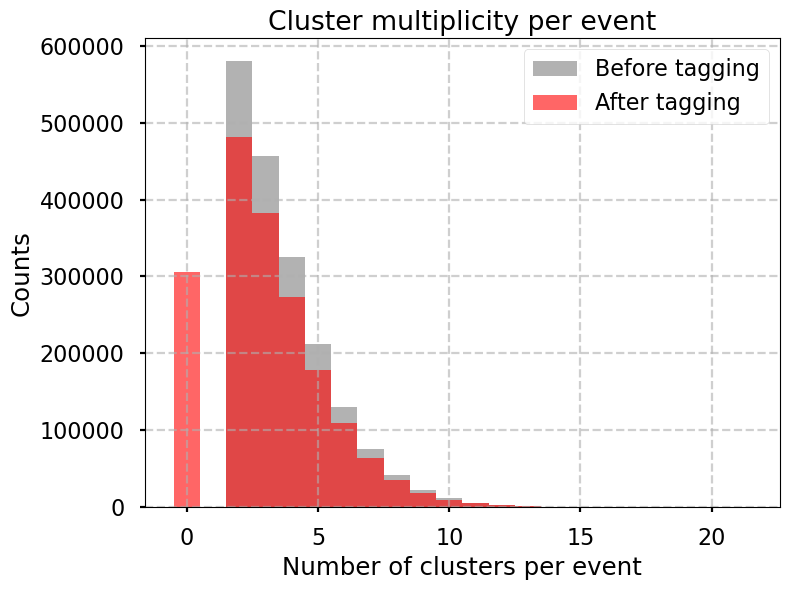

In [44]:
# ======================
# Main loop
# ======================
Epi_all, Epi_pass = [], []
Q2_all, Q2_pass = [], []
event_idx_all, event_idx_pass = [], []

cluster_tags = []  # per-event boolean mask of tagged clusters

for i in tqdm(range(len(Ee)), desc="Processing events"):
    if Ee[i] < 3.5:
        cluster_tags.append(np.zeros(len(clusE[i]), dtype=bool))
        continue

    p4_eout = np.array([Ee[i], px_e[i], py_e[i], pz_e[i]])

    e_arr = np.array(clusE[i])
    x_arr = np.array(clusX[i])
    y_arr = np.array(clusY[i])

    tags = np.zeros(len(e_arr), dtype=bool)

    if len(e_arr) >= 2:
        for (i1, i2) in combinations(range(len(e_arr)), 2):
            e1, e2 = e_arr[i1], e_arr[i2]
            x1, y1 = x_arr[i1], y_arr[i1]
            x2, y2 = x_arr[i2], y_arr[i2]

            # photons
            ph1 = get_photon_4vector(e1, x1, y1)
            ph2 = get_photon_4vector(e2, x2, y2)

            p1x, p1y, p1z = rotate_nps_to_hall(ph1[1], ph1[2], ph1[3])
            p2x, p2y, p2z = rotate_nps_to_hall(ph2[1], ph2[2], ph2[3])

            p4_ph1 = np.array([ph1[0], p1x, p1y, p1z])
            p4_ph2 = np.array([ph2[0], p2x, p2y, p2z])

            p4_pi = p4_ph1 + p4_ph2
            E_pi = p4_pi[0]

            Q2_val = compute_Q2(p4_eout)

            # store all candidates
            Epi_all.append(E_pi)
            Q2_all.append(Q2_val)
            event_idx_all.append(i)

            if inequality_pass(E_pi, Ee[i], Q2_val):
                Epi_pass.append(E_pi)
                Q2_pass.append(Q2_val)
                event_idx_pass.append(i)
                tags[i1] = True
                tags[i2] = True

    cluster_tags.append(tags)

# ======================
# Convert to arrays
# ======================
Epi_all = np.array(Epi_all)
Epi_pass = np.array(Epi_pass)
Q2_all = np.array(Q2_all)
Q2_pass = np.array(Q2_pass)
event_idx_all = np.array(event_idx_all)
event_idx_pass = np.array(event_idx_pass)

# ======================
# Multiplicity distributions
# ======================
n_before = np.array([len(ev) for ev in clusE])
n_after  = np.array([tags.sum() for tags in cluster_tags])

plt.figure(figsize=(8,6))
bins = np.arange(0, max(n_before.max(), n_after.max())+2) - 0.5
plt.hist(n_before, bins=bins, alpha=0.6, label="Before tagging", color="gray")
plt.hist(n_after, bins=bins, alpha=0.6, label="After tagging", color="red")
plt.xlabel("Number of clusters per event")
plt.ylabel("Counts")
plt.title("Cluster multiplicity per event")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("cluster_multiplicity.png", dpi=200)
plt.show()

# ======================
# Save results
# ======================
# Full candidate list (all pairs)
pd.DataFrame({
    "event": event_idx_all,
    "Epi": Epi_all,
    "Q2": Q2_all
}).to_csv("/home/ubuntu/nps_analysis/pi0_analysis/pion_energy_all.csv", index=False)

# Tagged candidate list (only pairs passing inequality)
pd.DataFrame({
    "event": event_idx_pass,
    "Epi": Epi_pass,
    "Q2": Q2_pass
}).to_csv("/home/ubuntu/nps_analysis/pi0_analysis/pion_energy_pass.csv", index=False)

# Cluster-level tagging information
cluster_tag_df = []
for i, tags in enumerate(cluster_tags):
    for j, t in enumerate(tags):
        cluster_tag_df.append({
            "event": i,
            "cluster_index": j,
            "energy": float(clusE[i][j]),
            "x": float(clusX[i][j]),
            "y": float(clusY[i][j]),
            "tagged": bool(t)
        })

pd.DataFrame(cluster_tag_df).to_csv(
    "/home/ubuntu/nps_analysis/pi0_analysis/cluster_tags.csv", index=False
)


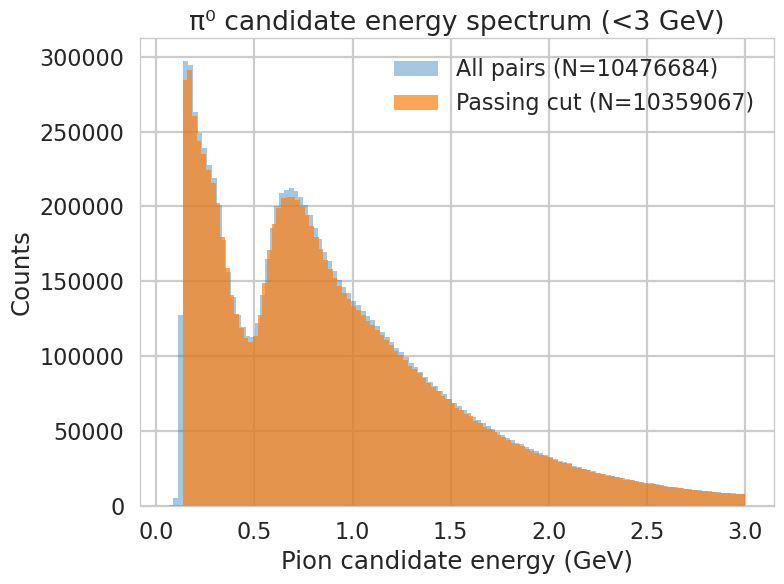

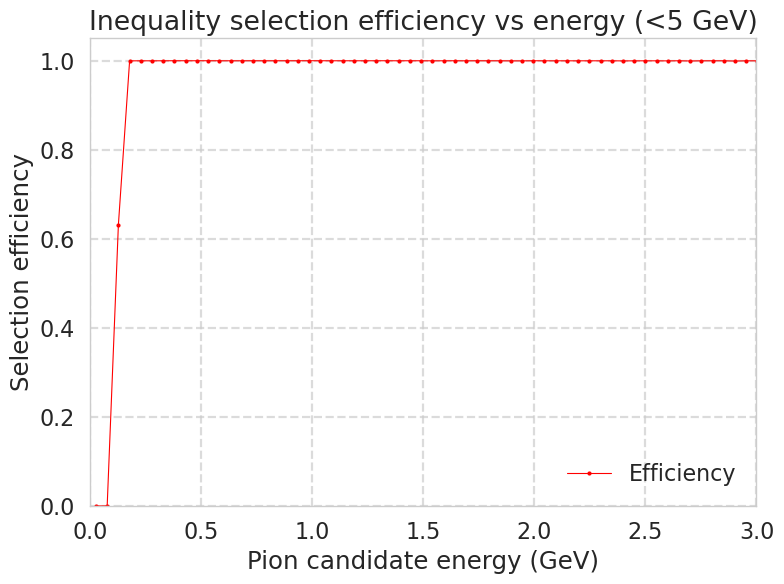

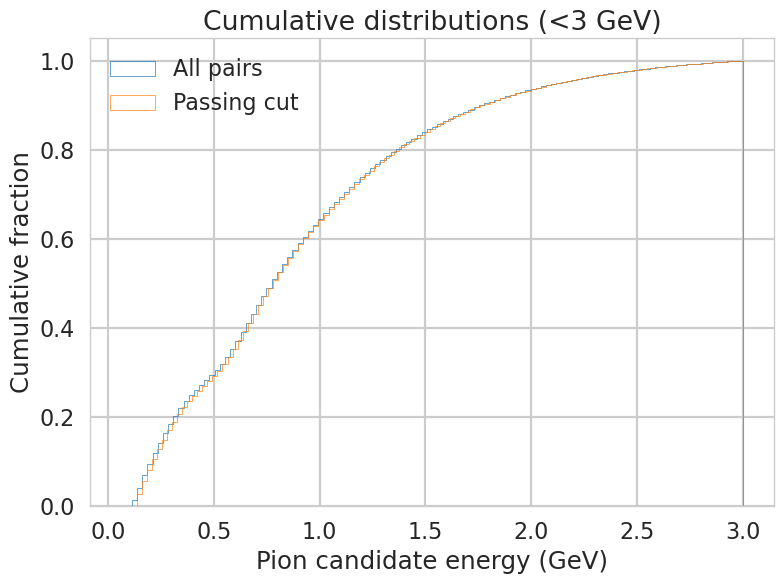

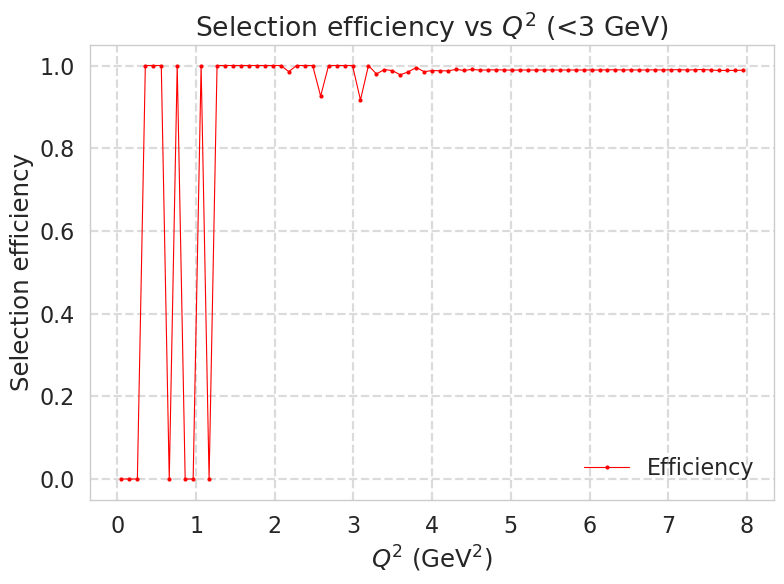

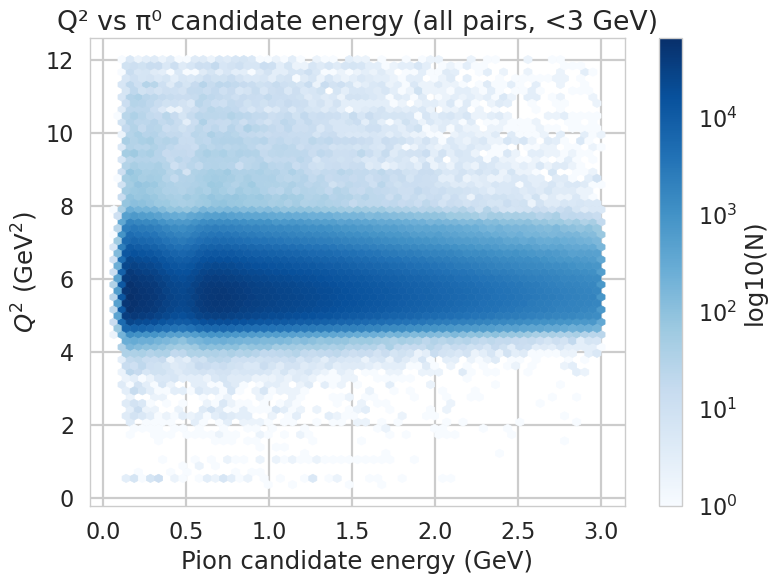

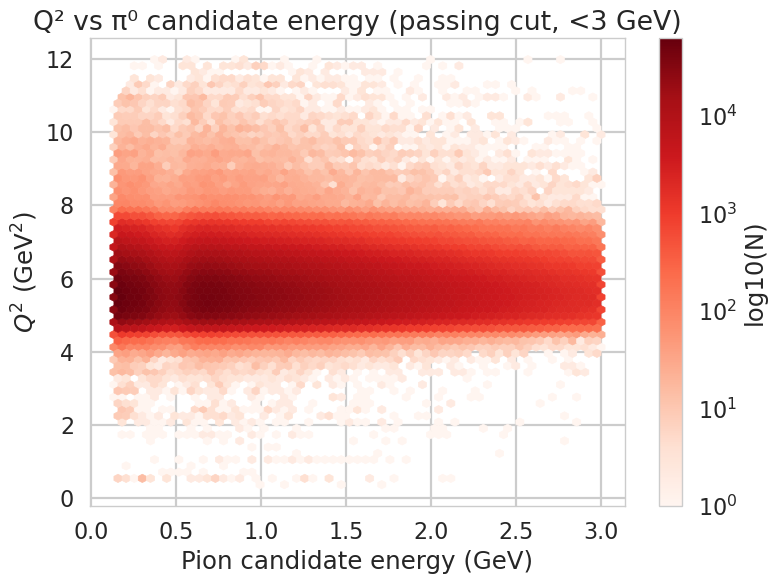

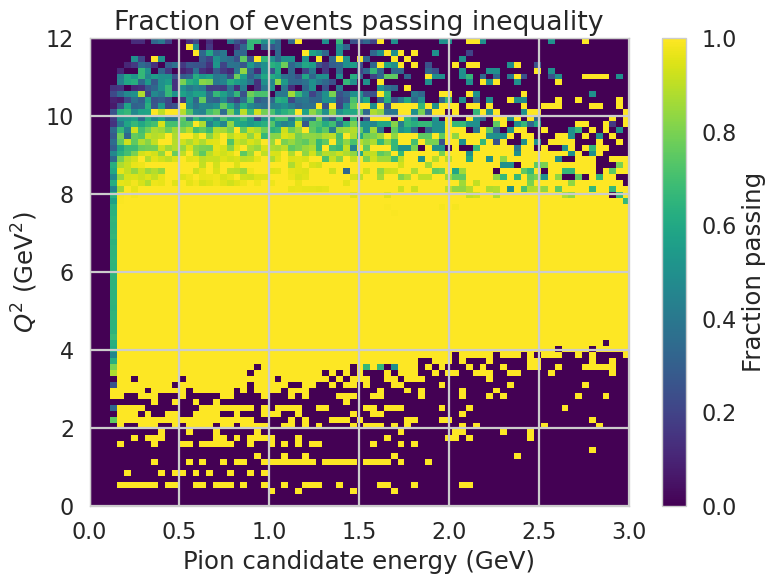

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")  # clean, consistent style
plt.rcParams.update({"font.size": 12})

# ======================
# Configuration
# ======================
DATA_DIR = Path("/home/ubuntu/nps_analysis/pi0_analysis")
FILE_ALL = DATA_DIR / "pion_energy_all.csv"
FILE_PASS = DATA_DIR / "pion_energy_pass.csv"

E_MAX = 3.0   # pion candidate energy cut (GeV)
Q2_MAX = 12.0 # Q² cut (GeV²)

# ======================
# Helper functions
# ======================
def load_and_clean(filepath):
    """Load CSV and drop invalid values."""
    df = pd.read_csv(filepath)
    return df.replace([np.inf, -np.inf], np.nan).dropna()

def compute_efficiency(values_all, values_pass, bins):
    """Return bin centers and efficiency array."""
    h_all, _ = np.histogram(values_all, bins)
    h_pass, _ = np.histogram(values_pass, bins)
    eff = h_pass / np.maximum(h_all, 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    return bin_centers, eff

def plot_efficiency(x, eff, xlabel, ylabel, title, fname, 
                    xlim=None, ylim=None, markersize=3, color="red"):
    """Generic efficiency plot with annotations and grid."""
    plt.figure(figsize=(8,6))
    plt.plot(x, eff, "o-", color=color, label="Efficiency", 
             markersize=markersize, linewidth=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim: plt.xlim(*xlim)
    if ylim: plt.ylim(*ylim)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    plt.close()

# ======================
# Load data
# ======================
df_all  = load_and_clean(FILE_ALL)
df_pass = load_and_clean(FILE_PASS)

Epi_all, Epi_pass = df_all["Epi"].to_numpy(), df_pass["Epi"].to_numpy()
Q2_all,  Q2_pass  = df_all["Q2"].to_numpy(),  df_pass["Q2"].to_numpy()

# ======================
# Apply cuts
# ======================
mask_all  = (0 < Epi_all) & (Epi_all < E_MAX) & (0 < Q2_all) & (Q2_all < Q2_MAX)
mask_pass = (0 < Epi_pass) & (Epi_pass < E_MAX) & (0 < Q2_pass) & (Q2_pass < Q2_MAX)

Epi_all_cut, Epi_pass_cut = Epi_all[mask_all], Epi_pass[mask_pass]
Q2_all_cut,  Q2_pass_cut  = Q2_all[mask_all],  Q2_pass[mask_pass]

# ======================
# 1. Energy spectrum comparison
# ======================
plt.figure(figsize=(8,6))
plt.hist(Epi_all_cut, bins=120, alpha=0.4, label=f"All pairs (N={len(Epi_all_cut)})")
plt.hist(Epi_pass_cut, bins=120, alpha=0.7, label=f"Passing cut (N={len(Epi_pass_cut)})")
plt.xlabel("Pion candidate energy (GeV)")
plt.ylabel("Counts")
plt.legend()
plt.title("π⁰ candidate energy spectrum (<3 GeV)")
plt.tight_layout()
plt.savefig("pion_energy_spectrum_cut.png", dpi=200)
plt.show()
plt.close()

# ======================
# 2. Efficiency vs energy
# ======================
bins = np.linspace(0, 5, 100)
x, eff = compute_efficiency(Epi_all_cut, Epi_pass_cut, bins)
plot_efficiency(x, eff, "Pion candidate energy (GeV)", "Selection efficiency",
                "Inequality selection efficiency vs energy (<5 GeV)",
                "selection_efficiency.png", xlim=(0,3), ylim=(0,1.05))

# # Zoomed-in version (to see small deviations near 1)
# bins_zoom = np.linspace(0.7, 3, 50)
# x_zoom, eff_zoom = compute_efficiency(Epi_all_cut, Epi_pass_cut, bins_zoom)
# plot_efficiency(x_zoom, eff_zoom, "Pion candidate energy (GeV)", "Selection efficiency",
#                 "Efficiency vs energy (zoomed)", 
#                 "selection_efficiency_zoomed.png", 
#                 xlim=(0.8,3), ylim=(0.99,1.005), markersize=2)

# ======================
# 3. Cumulative distributions
# ======================
plt.figure(figsize=(8,6))
plt.hist(Epi_all_cut, bins=120, histtype="step", cumulative=True, density=True, label="All pairs")
plt.hist(Epi_pass_cut, bins=120, histtype="step", cumulative=True, density=True, label="Passing cut")
plt.xlabel("Pion candidate energy (GeV)")
plt.ylabel("Cumulative fraction")
plt.legend()
plt.title("Cumulative distributions (<3 GeV)")
plt.tight_layout()
plt.savefig("cumulative_energy_cut.png", dpi=200)
plt.show()
plt.close()

# ======================
# 4. Efficiency vs Q²
# ======================
bins_q2 = np.linspace(0, 8, 80)
x_q2, eff_q2 = compute_efficiency(Q2_all_cut, Q2_pass_cut, bins_q2)
plot_efficiency(x_q2, eff_q2, r"$Q^2$ (GeV$^2$)", "Selection efficiency",
                "Selection efficiency vs $Q^2$ (<3 GeV)",
                "efficiency_vs_q2.png")

# ======================
# 5. Q² vs Pion energy (2D heatmaps)
# ======================
def plot_hexbin(x, y, xlabel, ylabel, title, fname, cmap):
    plt.figure(figsize=(8,6))
    hb = plt.hexbin(x, y, gridsize=60, cmap=cmap, bins="log")
    plt.colorbar(hb, label="log10(N)")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    plt.close()

plot_hexbin(Epi_all_cut, Q2_all_cut, "Pion candidate energy (GeV)", r"$Q^2$ (GeV$^2$)",
            "Q² vs π⁰ candidate energy (all pairs, <3 GeV)", "Q2_vs_pion_all.png", "Blues")

plot_hexbin(Epi_pass_cut, Q2_pass_cut, "Pion candidate energy (GeV)", r"$Q^2$ (GeV$^2$)",
            "Q² vs π⁰ candidate energy (passing cut, <3 GeV)", "Q2_vs_pion_pass.png", "Reds")

# ======================
# 6. 2D Fraction passing heatmap
# ======================
E_bins = np.linspace(0,3,80)
Q_bins = np.linspace(0,12,80)
H_all, _, _  = np.histogram2d(Epi_all_cut, Q2_all_cut, bins=[E_bins, Q_bins])
H_pass, _, _ = np.histogram2d(Epi_pass_cut, Q2_pass_cut, bins=[E_bins, Q_bins])
fraction = H_pass / np.maximum(H_all, 1)

plt.figure(figsize=(8,6))
plt.imshow(fraction.T, origin="lower", aspect="auto",
           extent=[E_bins[0], E_bins[-1], Q_bins[0], Q_bins[-1]],
           cmap="viridis", vmin=0, vmax=1)
plt.colorbar(label="Fraction passing")
plt.xlabel("Pion candidate energy (GeV)")
plt.ylabel(r"$Q^2$ (GeV$^2$)")
plt.title("Fraction of events passing inequality")
plt.tight_layout()
plt.savefig("fraction_passing_2D.png", dpi=200)
plt.show()
plt.close()

# ======================
# Save efficiency data to CSV for reference
# ======================
pd.DataFrame({"E_bin_center": x, "Efficiency": eff}).to_csv("efficiency_vs_energy.csv", index=False)
pd.DataFrame({"Q2_bin_center": x_q2, "Efficiency": eff_q2}).to_csv("efficiency_vs_Q2.csv", index=False)

In [39]:
# df_pass.head(20)
df_pass[df_pass["Q2"]<10].head(20)


,event,Epi,Q2
0,1847,7.981404,5.945292
1,1893,8.669268,5.161979
2,4658,8.823151,6.515052
3,4658,7.912769,6.515052
4,6641,9.538184,4.953940
5,7247,8.161660,5.509469
6,10629,7.778424,5.100266
7,15035,8.105577,5.002960
8,20115,7.929041,4.945662
9,21720,10.097658,5.145604


In [25]:
df_tag = pd.read_csv('/home/ubuntu/nps_analysis/pi0_analysis/cluster_tags.csv')

In [58]:
df_tag[df_tag["tagged"] == True].head(20)


,event,cluster_index,energy,x,y,tagged
7075,1847,0,2.641235,-10.843377,-18.221681,True
7076,1847,1,5.340169,-24.640421,25.391814,True
7243,1893,1,6.050050,1.168331,25.816483,True
7245,1893,3,2.619218,-27.425994,25.784791,True
17536,4658,0,1.772974,-11.801531,-30.588974,True
17537,4658,1,7.050177,-25.080151,-22.564584,True
17538,4658,2,0.862592,-0.509964,-1.535941,True
25037,6641,0,4.608309,-25.509474,28.111293,True
25038,6641,1,4.929875,-5.943875,0.080430,True
27329,7247,1,2.419366,21.152882,-1.789110,True


In [51]:
print("Epi_pass min/max:", Epi_pass.min(), Epi_pass.max())
print("Q2_pass min/max:", Q2_pass.min(), Q2_pass.max())

# Pion candidate energy must be < 3 GeV
mask_all  = (Epi_all > 0) & (Epi_all < 3)
mask_pass = (Epi_pass > 0) & (Epi_pass < 3)

# Q² should also be positive and within a sensible range (< 20 GeV² here, adjust as needed)
# mask_all  &= (Q2_all > 0) & (Q2_all < 20)
# mask_pass &= (Q2_pass > 0) & (Q2_pass < 20)

print("Number of events passing mask_pass:", np.sum(mask_pass))


Epi_pass min/max: 0.1350001037597656 16.610187177734375
Q2_pass min/max: 0.3584179234638291 57.97459948950944
Number of events passing mask_pass: 5197437


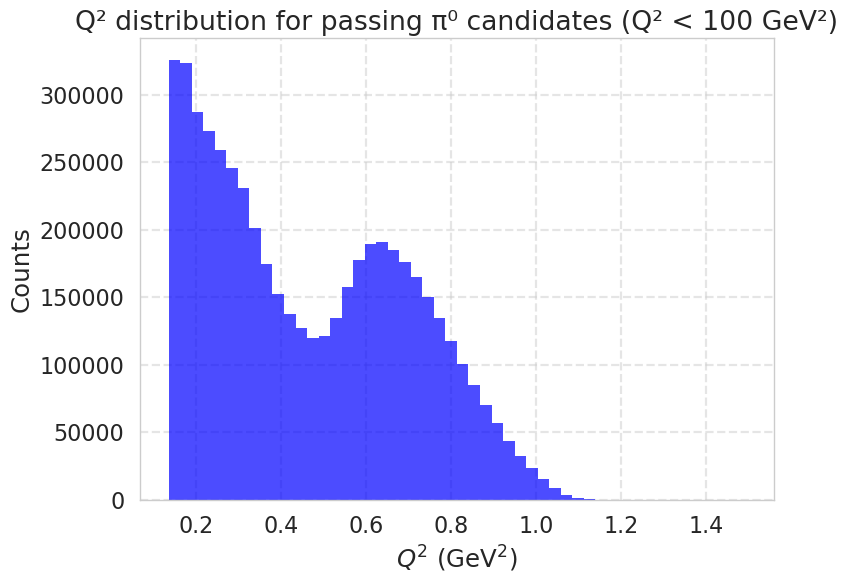

In [62]:
# plt.figure(figsize=(6,5))
# plt.scatter(df_pass["Epi"], df_pass["Q2"], s=10, alpha=0.5)
# plt.axvline(3.0, color='r', linestyle='--', label='Epi < 3')
# plt.axhline(20.0, color='g', linestyle='--', label='Q2 < 20')
# plt.xlabel("Epi")
# plt.ylabel("Q2")
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import pandas as pd

# Load CSV
df_pass = pd.read_csv("/home/ubuntu/nps_analysis/pi0_analysis/pion_energy_pass.csv")

# Extract Q² values and restrict to < 100
Q2_pass = df_pass["Epi"].to_numpy()
Q2_pass_cut = Q2_pass[Q2_pass < 1.5]

# Plot histogram
plt.figure(figsize=(8,6))
plt.hist(Q2_pass_cut, bins=50, alpha=0.7, color="blue")
plt.xlabel(r"$Q^2$ (GeV$^2$)")
plt.ylabel("Counts")
plt.title("Q² distribution for passing π⁰ candidates (Q² < 100 GeV²)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



In [63]:
df_tag.head(20)

,event,cluster_index,energy,x,y,tagged
0,0,0,0.276418,-21.415044,5.400000,False
1,0,1,0.620013,-19.578662,-33.480000,False
2,0,2,0.075619,-24.840000,-27.000000,False
3,0,3,0.242769,-20.520000,-31.320000,False
4,1,0,0.489423,9.720000,-19.293212,False
5,1,1,0.062274,-24.840000,16.200000,False
6,2,0,0.248884,-14.040000,-37.800000,False
7,2,1,0.286875,-18.360000,-1.080000,False
8,3,0,0.665793,1.914102,-21.517999,False
9,3,1,0.612163,15.737954,37.368527,False


Loading CSV (columns expected: event, cluster_index, energy, x, y, tag or tagged)...
Found 1867180 unique events, 6982758 clusters total.
Processing events in compiled numba function (this may take some time but is C-fast)...
Saved augmented CSV to cluster_tags_with_opening_angle.csv
Saved mass lists to pi0_masses_*.txt


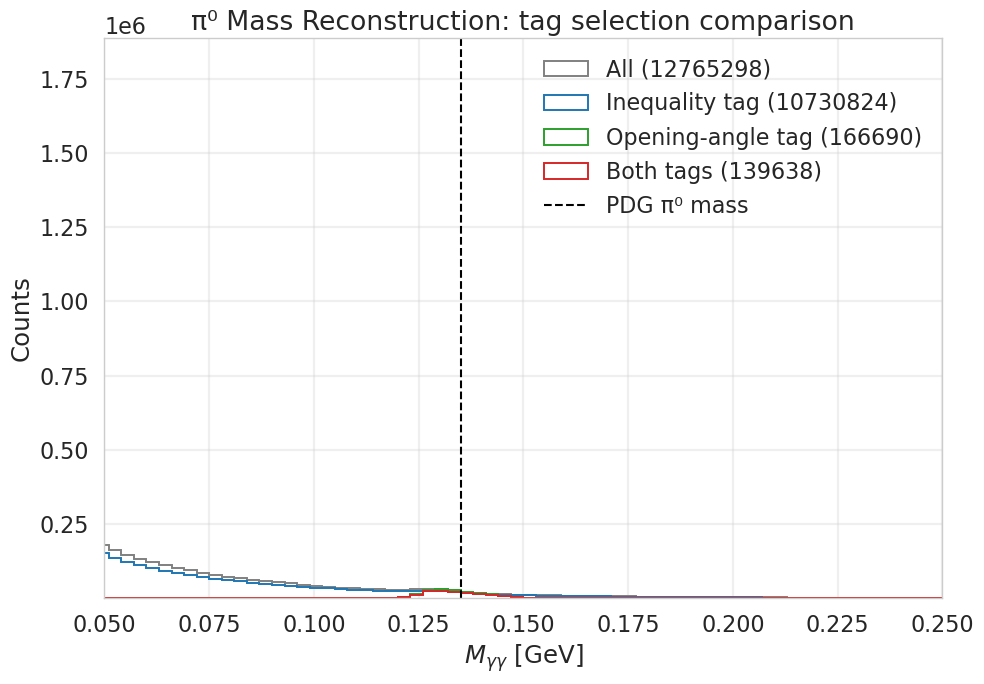

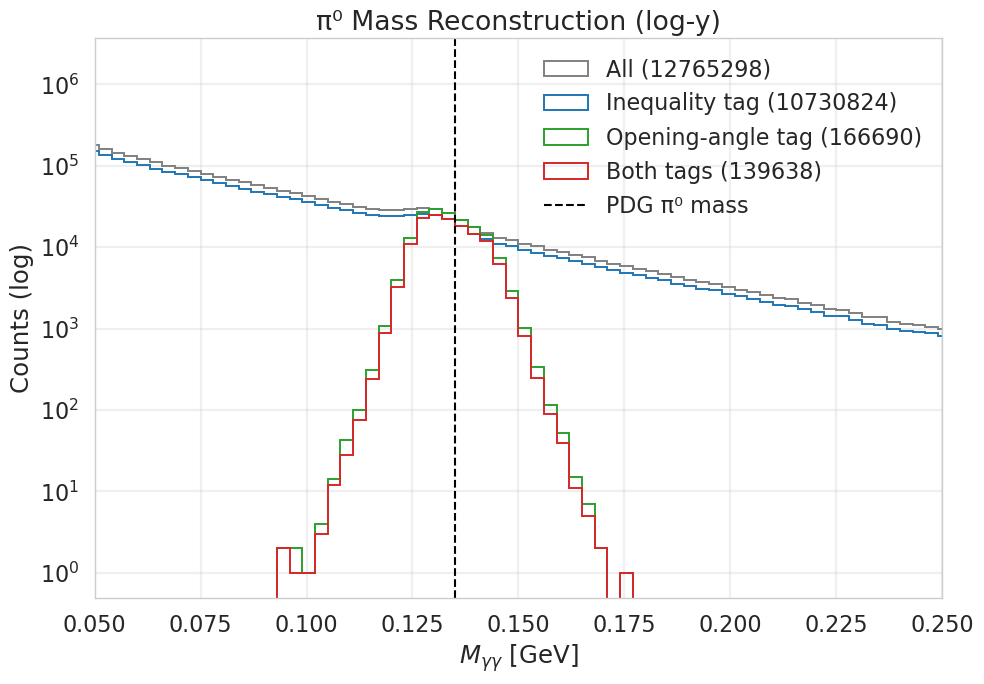

All: 12765298 entries | mean=0.0279 | std=0.0340 | median=0.0159
Tag only: 10730824 entries | mean=0.0278 | std=0.0338 | median=0.0159
OA only: 166690 entries | mean=0.1336 | std=0.0067 | median=0.1329
Both: 139638 entries | mean=0.1336 | std=0.0067 | median=0.1329


In [ ]:
#!/usr/bin/env python3
"""
Fast π0 reconstruction + opening-angle tagging for huge cluster_tags.csv

Requirements:
    numpy, pandas, matplotlib, numba, tqdm

Usage:
    python fast_pi0_opening_angle.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numba as nb
from numba import types
from numba.typed import List

# ======================
# User-tunable parameters
# ======================
INPUT_CSV = "cluster_tags.csv"                 # input file
OUT_CSV   = "cluster_tags_with_opening_angle.csv"
Z_NPS     = 407.0                              # cm
M_PION0   = 0.135                              # GeV
OPENING_ANGLE_TOL = 0.01                       # radians ~ tolerance used previously (~1 cm/4.07m)
MASS_HIST_RANGE = (0.0, 0.3)
MASS_HIST_BINS  = 100

# ======================
# Numba helpers (fast math)
# ======================
@nb.njit
def unit_vec_from_xy(x, y, z_nps):
    r0 = x
    r1 = y
    r2 = z_nps
    norm = (r0*r0 + r1*r1 + r2*r2) ** 0.5
    return r0 / norm, r1 / norm, r2 / norm

@nb.njit
def reconstruct_mass_nb(e1, e2, x1, y1, x2, y2, z_nps):
    # compute directions
    u10, u11, u12 = unit_vec_from_xy(x1, y1, z_nps)
    u20, u21, u22 = unit_vec_from_xy(x2, y2, z_nps)
    # momentum vectors p = E * u
    p10, p11, p12 = e1 * u10, e1 * u11, e1 * u12
    p20, p21, p22 = e2 * u20, e2 * u21, e2 * u22
    total_E = e1 + e2
    tp0 = p10 + p20
    tp1 = p11 + p21
    tp2 = p12 + p22
    p2 = tp0*tp0 + tp1*tp1 + tp2*tp2
    m2 = total_E*total_E - p2
    if m2 > 0.0:
        return np.sqrt(m2)
    else:
        return 0.0

@nb.njit
def passes_opening_angle_nb(e1, e2, x1, y1, x2, y2, z_nps, m_pion0, tol):
    # compute unit vectors
    u10, u11, u12 = unit_vec_from_xy(x1, y1, z_nps)
    u20, u21, u22 = unit_vec_from_xy(x2, y2, z_nps)
    dot = u10*u20 + u11*u21 + u12*u22
    if dot > 1.0:
        dot = 1.0
    elif dot < -1.0:
        dot = -1.0
    theta_data = np.arccos(dot)
    # ideal opening angle from kinematics (protect domain)
    denom = 4.0 * e1 * e2
    if denom <= 0.0:
        return False
    arg = m_pion0 * m_pion0 / denom
    # need arg <= 1 for arcsin; numeric slop clamp
    if arg > 1.0:
        # extremely small opening angle expected (unresolvable)
        # we treat as not passing (user can change policy)
        return False
    theta_ideal = 2.0 * np.arcsin(np.sqrt(arg))  # note: arcsin(sqrt(arg)) gives arcsin(m/(2*sqrt(E1E2))) -- equivalent
    return np.abs(theta_data - theta_ideal) < tol

# ======================
# Core Numba worker
# ======================
@nb.njit
def process_all_events(
    energy, xs, ys, event_ids, orig_tag_arr,
    event_starts, event_lens,
    z_nps, m_pion0, tol
):
    """
    energy, xs, ys, orig_tag_arr: flat arrays aligned with rows
    event_starts, event_lens: arrays of ints giving start index and length per event (both same indexing)
    Returns:
      opening_tag_out (boolean array same length as energy, modified in place)
      four numba.typed.Lists of masses: all_masses, tag_masses, oa_masses, both_masses
    """
    nrows = energy.shape[0]
    opening_tag = np.zeros(nrows, dtype=np.bool_)

    # typed lists for masses
    all_masses = List.empty_list(nb.float64)
    tag_masses = List.empty_list(nb.float64)
    oa_masses  = List.empty_list(nb.float64)
    both_masses= List.empty_list(nb.float64)

    nevents = event_starts.shape[0]
    for ev_idx in range(nevents):
        start = event_starts[ev_idx]
        length = event_lens[ev_idx]
        if length < 2:
            continue
        # for each pair within the event
        for a in range(length - 1):
            ia = start + a
            e1 = energy[ia]; x1 = xs[ia]; y1 = ys[ia]; t1 = orig_tag_arr[ia]
            for b in range(a+1, length):
                ib = start + b
                e2 = energy[ib]; x2 = xs[ib]; y2 = ys[ib]; t2 = orig_tag_arr[ib]

                # opening angle check
                oa = passes_opening_angle_nb(e1, e2, x1, y1, x2, y2, z_nps, m_pion0, tol)
                if oa:
                    opening_tag[ia] = True
                    opening_tag[ib] = True

                # reconstruct mass (no cut)
                m = reconstruct_mass_nb(e1, e2, x1, y1, x2, y2, z_nps)
                if m > 0.0:
                    all_masses.append(m)
                    if t1 and t2:
                        tag_masses.append(m)
                    if oa:
                        oa_masses.append(m)
                    if t1 and t2 and oa:
                        both_masses.append(m)
    return opening_tag, all_masses, tag_masses, oa_masses, both_masses

# ======================
# Python orchestration
# ======================
# def main():
print("Loading CSV (columns expected: event, cluster_index, energy, x, y, tag or tagged)...")
df = pd.read_csv(INPUT_CSV)

# Normalize tag column name to 'tag' boolean
if "tag" in df.columns:
    tagcol = "tag"
elif "tagged" in df.columns:
    tagcol = "tagged"
elif "is_tag" in df.columns:
    tagcol = "is_tag"
else:
    # If none exist, create a default all-True (or all-False). We default to False.
    print("No 'tag'/'tagged' column found; creating 'tag' as all False.")
    df["tag"] = False
    tagcol = "tag"

# Ensure types: energy,x,y numeric; tag -> bool
for col in ["energy", "x", "y"]:
    if col not in df.columns:
        raise RuntimeError(f"Required column '{col}' not found in {INPUT_CSV}")
df["energy"] = pd.to_numeric(df["energy"], errors="coerce")
df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")
# convert tag to boolean
df[tagcol] = df[tagcol].astype(bool)

# Sort by event then cluster_index to have contiguous blocks
if "cluster_index" in df.columns:
    df = df.sort_values(["event", "cluster_index"]).reset_index(drop=True)
else:
    df = df.sort_values(["event"]).reset_index(drop=True)

# Build flat arrays
energy = df["energy"].to_numpy(dtype=np.float64)
xs = df["x"].to_numpy(dtype=np.float64)
ys = df["y"].to_numpy(dtype=np.float64)
orig_tag_arr = df[tagcol].to_numpy(dtype=np.bool_)
event_ids = df["event"].to_numpy(dtype=np.int64)

# Build event_starts and event_lens
unique_events, idx_start, counts = np.unique(event_ids, return_index=True, return_counts=True)
# idx_start is the first index of each unique event (since event_ids are in sorted order)
event_starts = idx_start.astype(np.int64)
event_lens = counts.astype(np.int64)
nevents = unique_events.shape[0]
print(f"Found {nevents} unique events, {energy.shape[0]} clusters total.")

# Call numba worker
print("Processing events in compiled numba function (this may take some time but is C-fast)...")
opening_tag_arr, all_masses_list, tag_masses_list, oa_masses_list, both_masses_list = \
    process_all_events(energy, xs, ys, event_ids, orig_tag_arr,
                        event_starts, event_lens,
                        Z_NPS, M_PION0, OPENING_ANGLE_TOL)

# Convert typed lists to numpy arrays
def typed_list_to_np(typed_list):
    n = len(typed_list)
    arr = np.empty(n, dtype=np.float64)
    for i in range(n):
        arr[i] = typed_list[i]
    return arr

m_all = typed_list_to_np(all_masses_list)
m_tag = typed_list_to_np(tag_masses_list)
m_oa  = typed_list_to_np(oa_masses_list)
m_both= typed_list_to_np(both_masses_list)

# Assign opening_angle_tag back to DataFrame and save
df["opening_angle_tag"] = opening_tag_arr
df.to_csv(OUT_CSV, index=False)
print(f"Saved augmented CSV to {OUT_CSV}")

# Save mass lists
np.savetxt("pi0_masses_all.txt", m_all)
np.savetxt("pi0_masses_tag.txt", m_tag)
np.savetxt("pi0_masses_oa.txt", m_oa)
np.savetxt("pi0_masses_both.txt", m_both)
print("Saved mass lists to pi0_masses_*.txt")

# # Plot overlayed histograms (log y optional)
# plt.figure(figsize=(10,7))
# bins = np.linspace(MASS_HIST_RANGE[0], MASS_HIST_RANGE[1], MASS_HIST_BINS + 1)
# kwargs = dict(histtype="step", linewidth=1.2)

# plt.hist(m_all, bins=bins, label=f"All ({len(m_all)})", color="0.5", **kwargs)
# plt.hist(m_tag, bins=bins, label=f"Tag only ({len(m_tag)})", color="C0", **kwargs)
# plt.hist(m_oa,  bins=bins, label=f"OA only ({len(m_oa)})", color="C2", **kwargs)
# plt.hist(m_both,bins=bins, label=f"Both ({len(m_both)})", color="C3", **kwargs)

# plt.axvline(M_PION0, color="k", linestyle="--", label="PDG π0 mass")
# plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]")
# plt.ylabel("Counts")
# plt.title("π⁰ Mass Reconstruction: comparison of tag selections")
# plt.legend()
# plt.grid(alpha=0.25)
# plt.tight_layout()
# plt.savefig("pi0_mass_comparison.png", dpi=200)
# plt.show()

MASS_HIST_RANGE = (0.0, 0.3)   # focus on π0 peak region
MASS_HIST_BINS  = 100

# These should already be defined from your reconstruction
# m_all = invariant masses of all cluster pairs
# m_tag = masses with inequality tag
# m_oa  = masses with opening-angle tag
# m_both= masses with both selections

# ==========================
# Plot overlayed histograms
# ==========================
plt.figure(figsize=(10,7))
bins = np.linspace(MASS_HIST_RANGE[0], MASS_HIST_RANGE[1], MASS_HIST_BINS + 1)
kwargs = dict(histtype="step", linewidth=1.4)

plt.hist(m_all,  bins=bins, label=f"All ({len(m_all)})",  color="0.5", **kwargs)
plt.hist(m_tag,  bins=bins, label=f"Inequality tag ({len(m_tag)})", color="C0", **kwargs)
plt.hist(m_oa,   bins=bins, label=f"Opening-angle tag ({len(m_oa)})", color="C2", **kwargs)
plt.hist(m_both, bins=bins, label=f"Both tags ({len(m_both)})", color="C3", **kwargs)

plt.axvline(M_PION0, color="k", linestyle="--", linewidth=1.5, label="PDG π⁰ mass")

plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.title("π⁰ Mass Reconstruction: tag selection comparison")

plt.xlim(0.05, 0.25)   # zoom around π0 peak
# plt.ylim(bottom=1)     # avoids log(0) issues
plt.ylim()
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pi0_mass_comparison_zoom.png", dpi=200)
plt.show()

# ==========================
# Optional: log-scale version
# ==========================
plt.figure(figsize=(10,7))
plt.hist(m_all,  bins=bins, label=f"All ({len(m_all)})",  color="0.5", **kwargs)
plt.hist(m_tag,  bins=bins, label=f"Inequality tag ({len(m_tag)})", color="C0", **kwargs)
plt.hist(m_oa,   bins=bins, label=f"Opening-angle tag ({len(m_oa)})", color="C2", **kwargs)
plt.hist(m_both, bins=bins, label=f"Both tags ({len(m_both)})", color="C3", **kwargs)

plt.axvline(M_PION0, color="k", linestyle="--", linewidth=1.5, label="PDG π⁰ mass")

plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts (log)")
plt.title("π⁰ Mass Reconstruction (log-y)")

plt.xlim(0.05, 0.25)
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pi0_mass_comparison_zoom_log.png", dpi=200)
plt.show()

# Print summaries
def print_stats(name, arr):
    if arr.size == 0:
        print(f"{name}: No entries")
    else:
        print(f"{name}: {arr.size} entries | mean={arr.mean():.4f} | std={arr.std():.4f} | median={np.median(arr):.4f}")

print_stats("All", m_all)
print_stats("Tag only", m_tag)
print_stats("OA only", m_oa)
print_stats("Both", m_both)

# if __name__ == "__main__":
#     main()


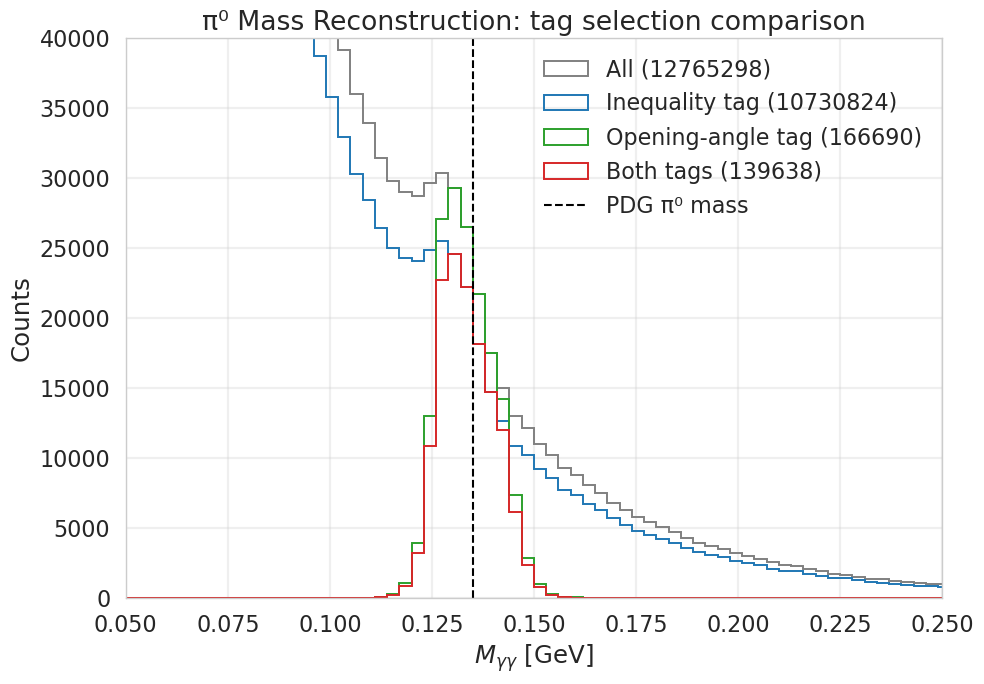

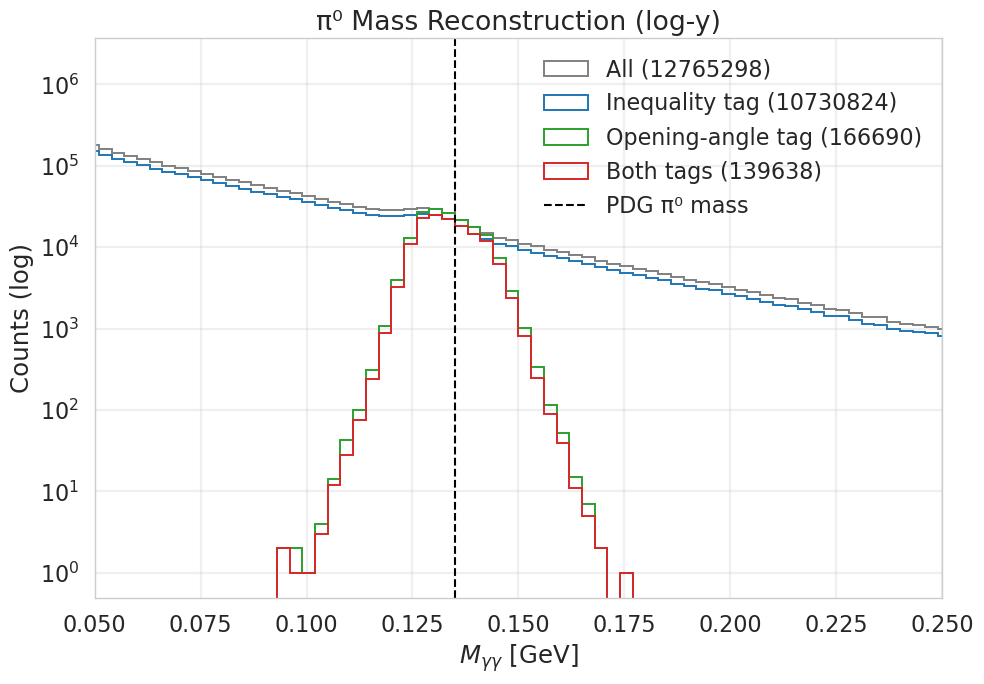

All: 12765298 entries | mean=0.0279 | std=0.0340 | median=0.0159
Tag only: 10730824 entries | mean=0.0278 | std=0.0338 | median=0.0159
OA only: 166690 entries | mean=0.1336 | std=0.0067 | median=0.1329
Both: 139638 entries | mean=0.1336 | std=0.0067 | median=0.1329


In [48]:
MASS_HIST_RANGE = (0.0, 0.3)   # focus on π0 peak region
MASS_HIST_BINS  = 100

# These should already be defined from your reconstruction
# m_all = invariant masses of all cluster pairs
# m_tag = masses with inequality tag
# m_oa  = masses with opening-angle tag
# m_both= masses with both selections

# ==========================
# Plot overlayed histograms
# ==========================
plt.figure(figsize=(10,7))
bins = np.linspace(MASS_HIST_RANGE[0], MASS_HIST_RANGE[1], MASS_HIST_BINS + 1)
kwargs = dict(histtype="step", linewidth=1.4)

plt.hist(m_all,  bins=bins, label=f"All ({len(m_all)})",  color="0.5", **kwargs)
plt.hist(m_tag,  bins=bins, label=f"Inequality tag ({len(m_tag)})", color="C0", **kwargs)
plt.hist(m_oa,   bins=bins, label=f"Opening-angle tag ({len(m_oa)})", color="C2", **kwargs)
plt.hist(m_both, bins=bins, label=f"Both tags ({len(m_both)})", color="C3", **kwargs)

plt.axvline(M_PION0, color="k", linestyle="--", linewidth=1.5, label="PDG π⁰ mass")

plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.title("π⁰ Mass Reconstruction: tag selection comparison")

plt.xlim(0.05, 0.25)   # zoom around π0 peak
# plt.ylim(bottom=1)     # avoids log(0) issues
plt.ylim(0,40000)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pi0_mass_comparison_zoom.png", dpi=200)
plt.show()

# ==========================
# Optional: log-scale version
# ==========================
plt.figure(figsize=(10,7))
plt.hist(m_all,  bins=bins, label=f"All ({len(m_all)})",  color="0.5", **kwargs)
plt.hist(m_tag,  bins=bins, label=f"Inequality tag ({len(m_tag)})", color="C0", **kwargs)
plt.hist(m_oa,   bins=bins, label=f"Opening-angle tag ({len(m_oa)})", color="C2", **kwargs)
plt.hist(m_both, bins=bins, label=f"Both tags ({len(m_both)})", color="C3", **kwargs)

plt.axvline(M_PION0, color="k", linestyle="--", linewidth=1.5, label="PDG π⁰ mass")

plt.xlabel(r"$M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts (log)")
plt.title("π⁰ Mass Reconstruction (log-y)")

plt.xlim(0.05, 0.25)
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("pi0_mass_comparison_zoom_log.png", dpi=200)
plt.show()

# Print summaries
def print_stats(name, arr):
    if arr.size == 0:
        print(f"{name}: No entries")
    else:
        print(f"{name}: {arr.size} entries | mean={arr.mean():.4f} | std={arr.std():.4f} | median={np.median(arr):.4f}")

print_stats("All", m_all)
print_stats("Tag only", m_tag)
print_stats("OA only", m_oa)
print_stats("Both", m_both)

# if __name__ == "__main__":
#     main()


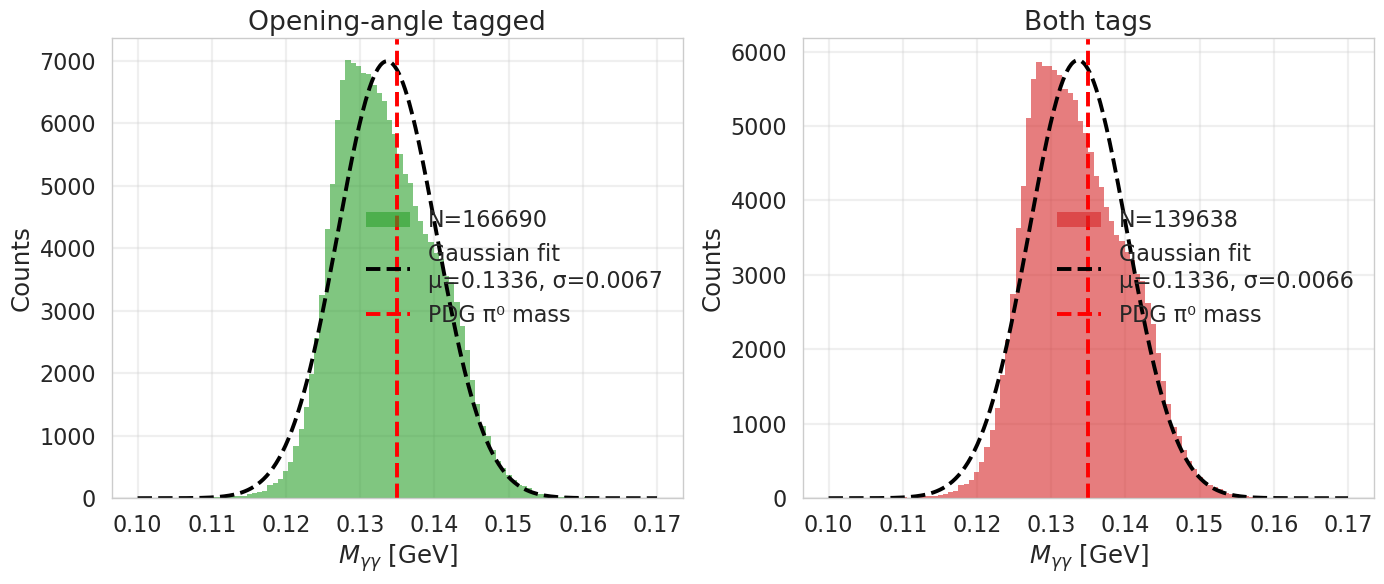

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# ------------------------
# Configuration
# ------------------------
M_PION0 = 0.135   # GeV
MASS_HIST_RANGE = (0.10, 0.17)  # full plotting range
MASS_HIST_BINS = 100

# ------------------------
# Function to fit and plot
# ------------------------
def plot_hist_gaussian(ax, data, title, fit_range, color="C0"):
    # Histogram over full plotting range
    counts, bins, patches = ax.hist(data, bins=MASS_HIST_BINS, range=MASS_HIST_RANGE,
                                    histtype="stepfilled", alpha=0.6, color=color, label=f"N={len(data)}")
    
    # Select data inside fit_range for Gaussian fitting
    fit_mask = (data >= fit_range[0]) & (data <= fit_range[1])
    data_fit = data[fit_mask]
    
    # Gaussian fit
    mu, sigma = norm.fit(data_fit)
    x_fit = np.linspace(MASS_HIST_RANGE[0], MASS_HIST_RANGE[1], 500)
    bin_width = (MASS_HIST_RANGE[1]-MASS_HIST_RANGE[0])/MASS_HIST_BINS
    y_fit = norm.pdf(x_fit, mu, sigma) * len(data_fit) * bin_width
    ax.plot(x_fit, y_fit, "k--", label=f"Gaussian fit\nμ={mu:.4f}, σ={sigma:.4f}")
    
    # PDG line
    ax.axvline(M_PION0, color="r", linestyle="--", label="PDG π⁰ mass")
    
    ax.set_xlabel(r"$M_{\gamma\gamma}$ [GeV]")
    ax.set_ylabel("Counts")
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)

# ------------------------
# Fit ranges for each subplot
# ------------------------
fit_range_oa   = (0.11, 0.16)   # opening-angle tagged
fit_range_both = (0.11, 0.16)   # both tags

# ------------------------
# Make figure
# ------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

plot_hist_gaussian(axes[0], m_oa, "Opening-angle tagged", fit_range_oa, color="C2")
plot_hist_gaussian(axes[1], m_both, "Both tags", fit_range_both, color="C3")

plt.tight_layout()
plt.show()




In [68]:
df_poop = pd.read_csv(OUT_CSV)

In [69]:
df_poop.head(20)

,event,cluster_index,energy,x,y,tagged,opening_angle_tag
0,0,0,0.276418,-21.415044,5.400000,True,False
1,0,1,0.620013,-19.578662,-33.480000,True,False
2,0,2,0.075619,-24.840000,-27.000000,True,False
3,0,3,0.242769,-20.520000,-31.320000,True,False
4,1,0,0.489423,9.720000,-19.293212,False,False
5,1,1,0.062274,-24.840000,16.200000,False,False
6,2,0,0.248884,-14.040000,-37.800000,True,False
7,2,1,0.286875,-18.360000,-1.080000,True,False
8,3,0,0.665793,1.914102,-21.517999,False,False
9,3,1,0.612163,15.737954,37.368527,False,False


In [2]:
df = pd.read_csv('cluster_tags_with_opening_angle.csv')

In [42]:
import pandas as pd

# Load CSV
df = pd.read_csv("cluster_tags_with_opening_angle.csv")

# Check the required columns
required_cols = {"event", "cluster_index", "tagged", "opening_angle_tag"}
if not required_cols.issubset(df.columns):
    raise RuntimeError(f"CSV missing required columns: {required_cols - set(df.columns)}")

# Filter clusters that have BOTH tags
df_both = df[(df["tagged"] == True) & (df["opening_angle_tag"] == True)]

# Count clusters per event
clusters_per_event = df_both.groupby("event").size()

# Count events with more than 2 clusters
events_with_gte2 = clusters_per_event[clusters_per_event == 2]
events_with_gt2 = clusters_per_event[clusters_per_event > 2]
# Total events with at least 1 cluster passing both tags
total_events_both_tag = df_both['event'].nunique()

print(f"Total events with ≥1 cluster passing both tags: {total_events_both_tag}")

print(f"Total events with ≥2 cluster passing both tags: {len(events_with_gte2)}")
print(f"Total events with ≥3 clusters and both tags: {len(events_with_gt2)}")
print(f"")
print("Example event counts:\n", events_with_gt2.head())


Total events with ≥1 cluster passing both tags: 38645
Total events with ≥2 cluster passing both tags: 3867
Total events with ≥3 clusters and both tags: 285

Example event counts:
 event
7247     3
26921    3
35383    3
50106    3
70936    4
dtype: int64


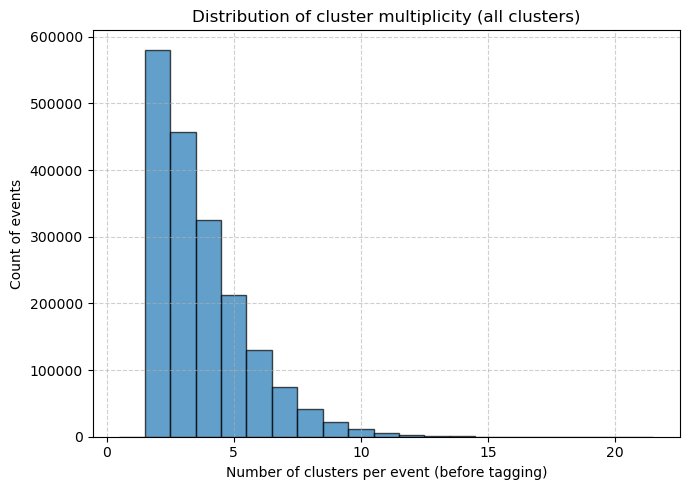

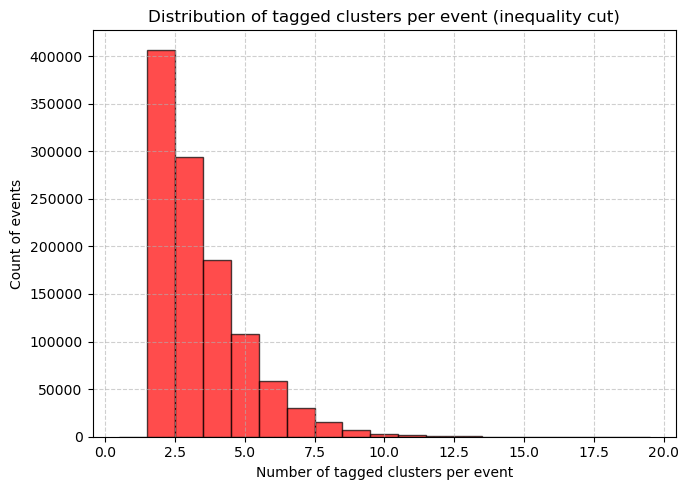

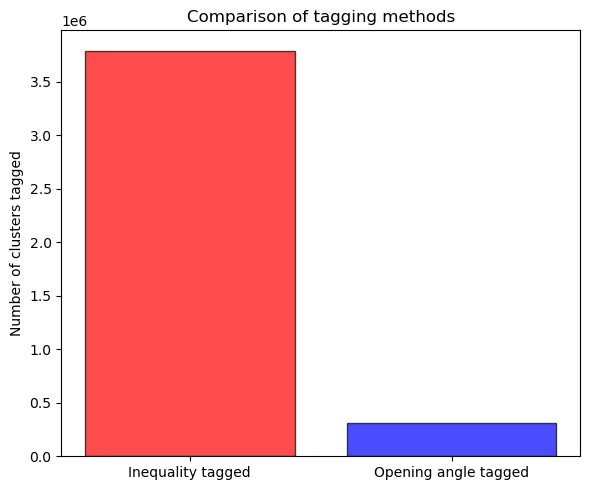

/tmp/ipykernel_1234/762014862.py:71: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_1234/762014862.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("cluster_positions_tagging.png", dpi=200)
/home/ubuntu/miniconda3/envs/everything/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


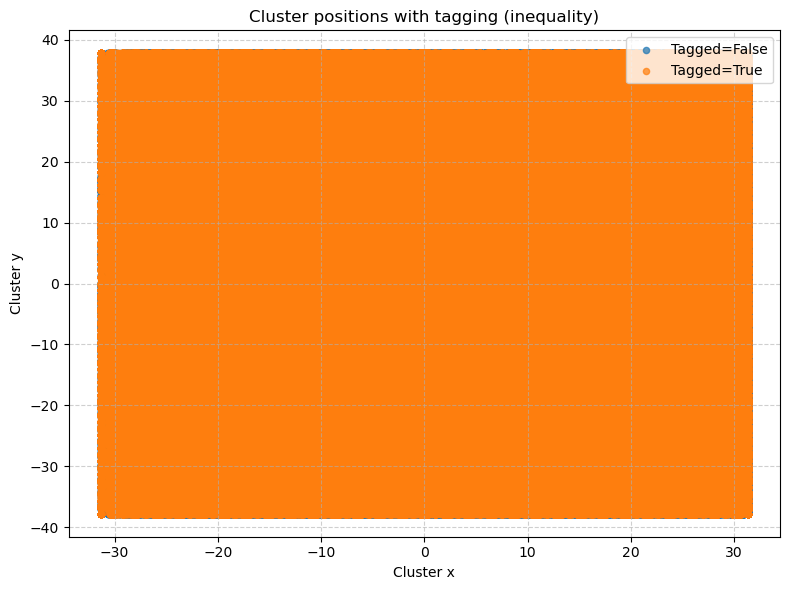

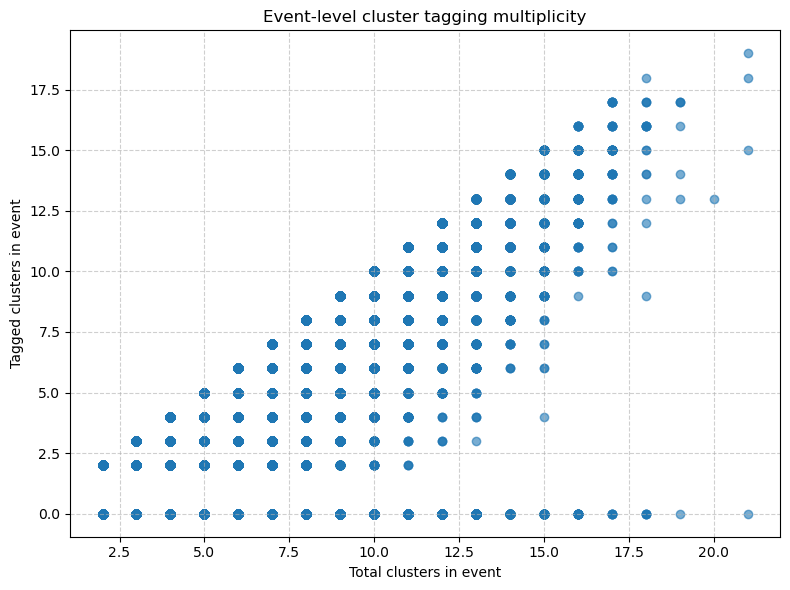

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# Load CSV
# =====================
df = pd.read_csv("cluster_tags_with_opening_angle.csv")

# =====================
# 1. Distribution of clusters per event (before tagging)
# =====================
clusters_per_event = df.groupby("event")["cluster_index"].count()

plt.figure(figsize=(7,5))
plt.hist(clusters_per_event, bins=range(1, clusters_per_event.max()+2), 
         align="left", edgecolor="black", alpha=0.7)
plt.xlabel("Number of clusters per event (before tagging)")
plt.ylabel("Count of events")
plt.title("Distribution of cluster multiplicity (all clusters)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("clusters_per_event_before_tagging.png", dpi=200)
plt.show()

# =====================
# 2. Distribution of tagged clusters per event
# =====================
tagged_per_event = df[df["tagged"]].groupby("event")["cluster_index"].count()

plt.figure(figsize=(7,5))
plt.hist(tagged_per_event, bins=range(1, tagged_per_event.max()+2), 
         align="left", edgecolor="black", alpha=0.7, color="red")
plt.xlabel("Number of tagged clusters per event")
plt.ylabel("Count of events")
plt.title("Distribution of tagged clusters per event (inequality cut)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("clusters_per_event_after_tagging.png", dpi=200)
plt.show()

# =====================
# 3. Compare tagging: inequality vs. opening-angle
# =====================
tag_counts = {
    "Inequality tagged": df["tagged"].sum(),
    "Opening angle tagged": df["opening_angle_tag"].sum()
}

plt.figure(figsize=(6,5))
plt.bar(tag_counts.keys(), tag_counts.values(), color=["red", "blue"], alpha=0.7, edgecolor="black")
plt.ylabel("Number of clusters tagged")
plt.title("Comparison of tagging methods")
plt.tight_layout()
plt.savefig("tagging_comparison.png", dpi=200)
plt.show()

# =====================
# 4. Event-level visualization: clusters tagged vs not
# =====================
# Example: scatter of x vs y for clusters, coloring tagged vs not
plt.figure(figsize=(8,6))
for tag_val, group in df.groupby("tagged"):
    plt.scatter(group["x"], group["y"], 
                s=20, label=f"Tagged={tag_val}", alpha=0.7)

plt.xlabel("Cluster x")
plt.ylabel("Cluster y")
plt.title("Cluster positions with tagging (inequality)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("cluster_positions_tagging.png", dpi=200)
plt.show()

# =====================
# 5. Event-level multiplicity heatmap (optional)
# =====================
# To see how many clusters remain per event after tagging
event_summary = pd.DataFrame({
    "all_clusters": clusters_per_event,
    "tagged_clusters": tagged_per_event
}).fillna(0)

plt.figure(figsize=(8,6))
plt.scatter(event_summary["all_clusters"], event_summary["tagged_clusters"], alpha=0.6)
plt.xlabel("Total clusters in event")
plt.ylabel("Tagged clusters in event")
plt.title("Event-level cluster tagging multiplicity")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("event_cluster_multiplicity.png", dpi=200)
plt.show()


In [ ]:
#!/usr/bin/env python3
"""
Full missing-mass reconstruction using cluster_tags_with_opening_angle.csv
and ROOT `branches` accessible in the environment (awkward arrays).

Outputs:
 - CSVs for per-event missing mass (best pair) for each tagging mode
 - PNG plots: pi0 mass for chosen pairs and proton missing mass histograms + overlay
No correction factors applied anywhere.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from math import sqrt

# -----------------------
# Configuration / constants
# -----------------------
E_beam = 8.457      # GeV (use the beam value you used for reconstruction)
M_PROTON = 0.9382720813
M_PION0 = 0.1349766
Z_NPS = 407.0       # cm (user specified)
THETA_DEG = -17.51  # rotation used previously (NPS -> Hall)
THETA_RAD = np.deg2rad(THETA_DEG)

# -----------------------
# Helper vector math
# -----------------------
def unit_vector_from_xy(x, y, z=Z_NPS):
    norm = np.sqrt(x*x + y*y + z*z)
    return x / norm, y / norm, z / norm

def photon_p4_from_cluster(E, x, y, z=Z_NPS):
    ux, uy, uz = unit_vector_from_xy(x, y, z)
    px = E * ux
    py = E * uy
    pz = E * uz
    return np.array([E, px, py, pz], dtype=float)

def rotate_nps_to_hall(p4, theta_rad=THETA_RAD):
    """Rotate 3-momentum about y-axis by theta (NPS->Hall). Input p4: [E, px, py, pz]."""
    E = p4[0]
    px, py, pz = p4[1], p4[2], p4[3]
    cos_t = np.cos(theta_rad)
    sin_t = np.sin(theta_rad)
    px_r = cos_t*px - sin_t*pz
    py_r = py
    pz_r = sin_t*px + cos_t*pz
    return np.array([E, px_r, py_r, pz_r], dtype=float)

def invariant_mass_from_p4(p4):
    m2 = p4[0]**2 - (p4[1]**2 + p4[2]**2 + p4[3]**2)
    return np.sqrt(m2) if m2 > 0 else np.nan

def missing_mass_proton(p4_ein, p4_pin, p4_eout, p4_pi0):
    p4_out = p4_eout + p4_pi0
    p4_miss = (p4_ein + p4_pin) - p4_out
    mm2 = p4_miss[0]**2 - (p4_miss[1]**2 + p4_miss[2]**2 + p4_miss[3]**2)
    return np.sqrt(mm2) if mm2 > 0 else np.nan

# Precompute incoming 4-vectors
p4_ein = np.array([E_beam, 0.0, 0.0, E_beam])
p4_pin = np.array([M_PROTON, 0.0, 0.0, 0.0])

# -----------------------
# Load CSV tags
# -----------------------
df_tags = pd.read_csv("cluster_tags_with_opening_angle.csv")
# expected columns: event, cluster_index, energy, x, y, tagged, opening_angle_tag

# Quick sanity: ensure columns exist
required_cols = {"event", "cluster_index", "energy", "x", "y", "tagged", "opening_angle_tag"}
if not required_cols.issubset(set(df_tags.columns)):
    raise RuntimeError(f"CSV missing required columns: {required_cols - set(df_tags.columns)}")

# -----------------------
# Branch access (awkward arrays)
# -----------------------
# These names must match your environment. Modify if your branches use different keys.
import awkward as ak
# Example branch names used earlier in conversation:
clusE = branches["NPS.cal.clusE"]
clusT = branches["NPS.cal.clusT"]
clusX = branches["NPS.cal.clusX"]
clusY = branches["NPS.cal.clusY"]

# Electron/HMS kinematics branches (per-event scalars)
Ee_arr  = ak.to_numpy(branches["H.gtr.p"])   # electron p ≈ Ee
px_e_arr = ak.to_numpy(branches["H.gtr.px"])
py_e_arr = ak.to_numpy(branches["H.gtr.py"])
pz_e_arr = ak.to_numpy(branches["H.gtr.pz"])

# Number of events in ROOT arrays (assumes one-to-one indexing with 'event' in CSV)
n_events = len(ak.to_numpy(ak.num(clusE)))

# -----------------------
# Helper: build per-event cluster dict from CSV
# -----------------------
# We'll use the CSV as authoritative for clusters (it contains tag flags).
clusters_by_event = {}
for row in df_tags.itertuples(index=False):
    ev = int(row.event)
    clusters_by_event.setdefault(ev, []).append({
        "cluster_index": int(row.cluster_index),
        "E": float(row.energy),
        "x": float(row.x),
        "y": float(row.y),
        "tagged": bool(row.tagged),
        "opening_angle_tag": bool(row.opening_angle_tag)
    })

# -----------------------
# Tagging modes to analyze
# -----------------------
modes = {
    "all": lambda c: True,
    "inequality_tagged": lambda c: c["tagged"],
    "opening_angle_tagged": lambda c: c["opening_angle_tag"]
}

# Containers for outputs
out_dfs = {}

# -----------------------
# Main loop over modes: pick best pair per event (closest to pi0 mass) and compute Mx
# -----------------------
for mode_name, selection_fn in modes.items():
    results = []  # store dicts per event: event, i, j, m_inv, Mx, e1, e2, x1,y1,x2,y2
    for ev, clist in clusters_by_event.items():
        # Filter clusters according to mode
        sel_clusters = [c for c in clist if selection_fn(c)]
        if len(sel_clusters) < 2:
            continue

        # For each pair, compute invariant mass and pick best (closest to M_PION0)
        best_pair = None
        best_diff = 1e9
        best_m4 = None
        for a, b in combinations(range(len(sel_clusters)), 2):
            c1 = sel_clusters[a]
            c2 = sel_clusters[b]
            p4_1 = photon_p4_from_cluster(c1["E"], c1["x"], c1["y"], z=Z_NPS)
            p4_2 = photon_p4_from_cluster(c2["E"], c2["x"], c2["y"], z=Z_NPS)
            p4_1h = rotate_nps_to_hall(p4_1, theta_rad=THETA_RAD)
            p4_2h = rotate_nps_to_hall(p4_2, theta_rad=THETA_RAD)
            p4_pi0 = p4_1h + p4_2h
            m_inv = invariant_mass_from_p4(p4_pi0)
            if np.isnan(m_inv):
                continue
            diff = abs(m_inv - M_PION0)
            if diff < best_diff:
                best_diff = diff
                best_pair = (c1, c2)
                best_m4 = p4_pi0

        if best_pair is None:
            continue

        # Get electron kinematics for this event from ROOT arrays
        # NOTE: we assume event indexing in CSV matches ROOT event array ordering
        if ev >= n_events:
            # event index out of range: skip
            continue
        Ee = float(Ee_arr[ev])
        px_e = float(px_e_arr[ev])
        py_e = float(py_e_arr[ev])
        pz_e = float(pz_e_arr[ev])
        p4_eout = np.array([Ee, px_e, py_e, pz_e])

        # Compute missing mass (no corrections)
        Mx = missing_mass_proton(p4_ein, p4_pin, p4_eout, best_m4)
        m_inv_best = invariant_mass_from_p4(best_m4)

        results.append({
            "event": ev,
            "cluster_i": best_pair[0]["cluster_index"],
            "cluster_j": best_pair[1]["cluster_index"],
            "e1": best_pair[0]["E"],
            "e2": best_pair[1]["E"],
            "x1": best_pair[0]["x"],
            "y1": best_pair[0]["y"],
            "x2": best_pair[1]["x"],
            "y2": best_pair[1]["y"],
            "m_pi0": m_inv_best,
            "Mx": Mx
        })

    # Save DataFrame for this mode
    df_mode = pd.DataFrame(results)
    out_dfs[mode_name] = df_mode
    df_mode.to_csv(f"missing_mass_bestpair_{mode_name}.csv", index=False)
    print(f"[mode={mode_name}] saved {len(df_mode)} events -> missing_mass_bestpair_{mode_name}.csv")

# -----------------------
# Plotting comparisons
# -----------------------
plt.style.use("seaborn-v0_8-whitegrid")
bins_mx = np.linspace(0.6, 1.1, 200)
bins_pi = np.linspace(0.0, 0.3, 200)

# pi0 mass distributions (best pairs)
plt.figure(figsize=(9,6))
for mode_name, dfm in out_dfs.items():
    plt.hist(dfm["m_pi0"].dropna(), bins=bins_pi, alpha=0.5, label=f"{mode_name} (N={len(dfm)})")
plt.axvline(M_PION0, color="k", linestyle="--", label="PDG π⁰")
plt.xlabel("Reconstructed π⁰ mass (GeV)")
plt.ylabel("Counts")
plt.title("π⁰ invariant mass (best pair per event) by tagging mode")
plt.legend()
plt.xlim(0.0, 0.3)
plt.savefig("pi0_mass_by_mode.png", dpi=200)
plt.close()

# missing mass distributions
plt.figure(figsize=(9,6))
for mode_name, dfm in out_dfs.items():
    plt.hist(dfm["Mx"].dropna(), bins=bins_mx, alpha=0.5, label=f"{mode_name} (N={len(dfm)})")
plt.axvline(M_PROTON, color="k", linestyle="--", label="Proton mass")
plt.xlabel("Missing mass (GeV)")
plt.ylabel("Counts")
plt.title("Missing mass (best pair per event) by tagging mode")
plt.legend()
plt.xlim(0.6, 1.1)
plt.savefig("missing_mass_by_mode.png", dpi=200)
plt.close()

# Overlay figure (zoomed around proton)
plt.figure(figsize=(9,6))
if len(out_dfs["all"]):  plt.hist(out_dfs["all"]["Mx"].dropna(), bins=bins_mx, alpha=0.4, label="all", color="gray")
if len(out_dfs["inequality_tagged"]): plt.hist(out_dfs["inequality_tagged"]["Mx"].dropna(), bins=bins_mx, alpha=0.5, label="inequality_tagged", color="red")
if len(out_dfs["opening_angle_tagged"]): plt.hist(out_dfs["opening_angle_tagged"]["Mx"].dropna(), bins=bins_mx, alpha=0.5, label="opening_angle_tagged", color="blue")
plt.axvline(M_PROTON, color="k", linestyle="--")
plt.xlabel("Missing mass (GeV)")
plt.ylabel("Counts")
plt.title("Missing mass comparison (best pair per event)")
plt.legend()
plt.xlim(0.8, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("missing_mass_overlay_bestpair.png", dpi=200)
plt.close()

# -----------------------
# Print simple summary stats
# -----------------------
for mode_name, dfm in out_dfs.items():
    arr = dfm["Mx"].dropna().values
    if len(arr)==0:
        print(f"{mode_name}: no entries")
        continue
    print(f"{mode_name}: N={len(arr)} mean={np.nanmean(arr):.4f} std={np.nanstd(arr):.4f} median={np.nanmedian(arr):.4f}")

print("Done. CSVs and plots saved in current directory.")


In [9]:
#!/usr/bin/env python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit

# -----------------------
# Configuration / constants
# -----------------------
E_beam = 10.537      # GeV
M_PROTON = 0.9382720813
M_PION0 = 0.1349766
Z_NPS = 407.0       # cm
THETA_DEG = -17.51
THETA_RAD = np.deg2rad(THETA_DEG)
COS_T, SIN_T = np.cos(THETA_RAD), np.sin(THETA_RAD)

# Precompute incoming 4-vectors
p4_ein = np.array([E_beam, 0.0, 0.0, E_beam])
p4_pin = np.array([M_PROTON, 0.0, 0.0, 0.0])

# -----------------------
# Fast math (numba JIT)
# -----------------------
@nb.njit(parallel=True)
def unit_vector_from_xy(x, y, z=Z_NPS):
    norm = (x*x + y*y + z*z)**0.5
    return x/norm, y/norm, z/norm

@nb.njit(parallel=True)
def photon_p4_from_cluster(E, x, y, z=Z_NPS):
    ux, uy, uz = unit_vector_from_xy(x, y, z)
    return np.array([E, E*ux, E*uy, E*uz])

@nb.njit(parallel=True)
def rotate_nps_to_hall(p4, cos_t=COS_T, sin_t=SIN_T):
    E, px, py, pz = p4
    px_r = cos_t*px - sin_t*pz
    py_r = py
    pz_r = sin_t*px + cos_t*pz
    return np.array([E, px_r, py_r, pz_r])

@nb.njit(parallel=True)
def invariant_mass_from_p4(p4):
    m2 = p4[0]**2 - (p4[1]**2 + p4[2]**2 + p4[3]**2)
    return np.sqrt(m2) if m2 > 0 else -1.0

@nb.njit(parallel=True)
def missing_mass_proton(p4_ein, p4_pin, p4_eout, p4_pi0):
    p4_out = p4_eout + p4_pi0
    p4_miss = (p4_ein + p4_pin) - p4_out
    mm2 = p4_miss[0]**2 - (p4_miss[1]**2 + p4_miss[2]**2 + p4_miss[3]**2)
    return np.sqrt(mm2) if mm2 > 0 else -1.0

@nb.njit(parallel=True)
def process_all_events(E_list, x_list, y_list, mask_list,
                       Ee_arr, px_arr, py_arr, pz_arr,
                       p4_ein, p4_pin, M_PION0):
    """
    E_list, x_list, y_list, mask_list: jagged arrays flattened
    with offsets array marking event boundaries.
    """
    n_events = len(E_list)
    results = []
    for ev in range(n_events):
        E = E_list[ev]
        x = x_list[ev]
        y = y_list[ev]
        mask = mask_list[ev]

        n = len(E)
        if n < 2:
            results.append((-1.0, -1.0, -1, -1, ev))
            continue

        best_diff = 1e9
        best_mpi0 = -1.0
        best_mx   = -1.0
        ci, cj = -1, -1

        for i in range(n):
            if not mask[i]:
                continue
            for j in range(i+1, n):
                if not mask[j]:
                    continue

                p4_1 = rotate_nps_to_hall(photon_p4_from_cluster(E[i], x[i], y[i]))
                p4_2 = rotate_nps_to_hall(photon_p4_from_cluster(E[j], x[j], y[j]))
                p4_pi0 = p4_1 + p4_2

                m_inv = invariant_mass_from_p4(p4_pi0)
                if m_inv < 0:
                    continue

                diff = abs(m_inv - M_PION0)
                if diff < best_diff:
                    p4_eout = np.array([Ee_arr[ev], px_arr[ev], py_arr[ev], pz_arr[ev]])
                    Mx = missing_mass_proton(p4_ein, p4_pin, p4_eout, p4_pi0)

                    best_diff = diff
                    best_mpi0 = m_inv
                    best_mx   = Mx
                    ci, cj = i, j

        results.append((best_mpi0, best_mx, ci, cj, ev))

    return results

# -----------------------
# Load CSV + ROOT branches
# -----------------------
df_tags = pd.read_csv("cluster_tags_with_opening_angle.csv")

import awkward as ak
Ee_arr  = ak.to_numpy(branches["H.gtr.p"])
px_arr  = ak.to_numpy(branches["H.gtr.px"])
py_arr  = ak.to_numpy(branches["H.gtr.py"])
pz_arr  = ak.to_numpy(branches["H.gtr.pz"])

n_events = len(Ee_arr)

# -----------------------
# Tagging modes
# -----------------------
modes = {
    "all": lambda df: np.ones(len(df), dtype=np.bool_),
    "inequality_tagged": lambda df: df["tagged"].values.astype(np.bool_),
    "opening_angle_tagged": lambda df: df["opening_angle_tag"].values.astype(np.bool_),
}

out_dfs = {}

for mode_name, sel_fn in modes.items():
    # Group by event into compact lists
    E_list, x_list, y_list, mask_list = [], [], [], []
    for ev in range(n_events):
        ev_df = df_tags[df_tags["event"]==ev]
        if ev_df.empty:
            E_list.append(np.empty(0))
            x_list.append(np.empty(0))
            y_list.append(np.empty(0))
            mask_list.append(np.empty(0, dtype=np.bool_))
            continue
        E_list.append(ev_df["energy"].to_numpy())
        x_list.append(ev_df["x"].to_numpy())
        y_list.append(ev_df["y"].to_numpy())
        mask_list.append(sel_fn(ev_df))

    results = process_all_events(E_list, x_list, y_list, mask_list,
                                 Ee_arr, px_arr, py_arr, pz_arr,
                                 p4_ein, p4_pin, M_PION0)

    df_mode = pd.DataFrame(results, columns=["m_pi0","Mx","ci","cj","event"])
    df_mode = df_mode[df_mode["ci"] >= 0]  # filter valid
    out_dfs[mode_name] = df_mode
    df_mode.to_csv(f"missing_mass_bestpair_{mode_name}.csv", index=False)
    print(f"[{mode_name}] -> {len(df_mode)} events")

# -----------------------
# Plots (same as before)
# -----------------------
plt.style.use("seaborn-v0_8-whitegrid")
bins_mx = np.linspace(0.6, 1.1, 200)
bins_pi = np.linspace(0.0, 0.3, 200)

plt.figure(figsize=(9,6))
for mode_name, dfm in out_dfs.items():
    plt.hist(dfm["m_pi0"], bins=bins_pi, alpha=0.5, label=f"{mode_name} (N={len(dfm)})")
plt.axvline(M_PION0, color="k", linestyle="--")
plt.xlabel("π⁰ mass (GeV)")
plt.ylabel("Counts")
plt.legend()
plt.savefig("pi0_mass_by_mode.png", dpi=200)
plt.show()
plt.close()

plt.figure(figsize=(9,6))
for mode_name, dfm in out_dfs.items():
    plt.hist(dfm["Mx"], bins=bins_mx, alpha=0.5, label=f"{mode_name} (N={len(dfm)})")
plt.axvline(M_PROTON, color="k", linestyle="--")
plt.xlabel("Missing mass (GeV)")
plt.ylabel("Counts")
plt.legend()
plt.savefig("missing_mass_by_mode.png", dpi=200)
plt.show()
plt.close()


KeyboardInterrupt: 